# XGBoost Using Historical and Google Trends Data
## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)

# Import Libraries <a name = "Import_Libraries"/>

In [1]:
import sys
import os
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import re
import pandas as pd                        # pandas, the magical dataframe library
import matplotlib.pyplot as plt             # matplotlib.pylot plots data 
plt.style.use('bmh')
import numpy as np                         # numpy provides N-dimensional object support 
import datetime as dt
import seaborn as sns
import math
import matplotlib.mlab as mlab
from sklearn import preprocessing
#conduct data plotting inline instead of in a separate windor
%matplotlib inline 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from math import sqrt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, plotting, space_eval
import mlflow

C:\Users\feras\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\feras\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\feras\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>
https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_XGBoost_GoogleTrends_MLFlow')

#else:
mlflow.set_experiment('Olist_XGBoost_GoogleTrends_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_XGBoost.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-1',
           'train_start': '2017-07-01',
           'valid_start': '2017-11-21'},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': True,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'window_size': 7},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start_date': '2016-11-01 00:00:00',
 'state': 'SP',
 'tables': {'customers': 'olist_custo

# Pre-Process Training, Validate and Test Datasets <a name = "Pre_Processing"/>

In [4]:
df_train, df_valid, df_test, = dataset_2.make_dataset(config)

#_=df_train.pop('order_approved_at').unique()

# Store dates for use in plotting results
#valid_dates = df_valid.pop('order_approved_at').unique()
#test_dates = df_test.pop('order_approved_at').unique()


# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [5]:
#Filter on product categories (series)
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_valid = df_valid.loc[df_valid['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table'].copy()

#Merge Google Trends Trends Series Extracted for the Product Category 
base_dir_1 = "C:\\Users\\feras\\Documents\\Thesis_2020\\GoogleTrendsSeries\\"

cama_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Cama_Shopping.csv'))
mesa_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Mesa_Shopping.csv'))
banho_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Banho_Shopping.csv'))
bed_bath_topic = pd.read_csv(os.path.join(base_dir_1,'Bed_Bath_Topic.csv'))

cama_gt_shopping = cama_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Cama GT'}) 
mesa_gt_shopping = mesa_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Mesa GT'}) 
banho_gt_shopping = banho_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Banho GT'}) 
bed_bath_topic = bed_bath_topic.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Bed & Bath':'Bed and Bath GT'}) 

df = pd.merge(cama_gt_shopping,mesa_gt_shopping,how='inner',on='order_approved_at')
df2 = pd.merge(df,banho_gt_shopping,how='inner',on='order_approved_at')
google_trends_series = pd.merge(df2,bed_bath_topic,how='inner',on='order_approved_at')
google_trends_series['order_approved_at'] =  pd.to_datetime(google_trends_series['order_approved_at'], infer_datetime_format=True)

google_trends_series["Cama GT"] = pd.to_numeric(google_trends_series["Cama GT"], downcast="float")
google_trends_series["Mesa GT"] = pd.to_numeric(google_trends_series["Mesa GT"], downcast="float")
google_trends_series["Banho GT"] = pd.to_numeric(google_trends_series["Banho GT"], downcast="float")
google_trends_series["Bed and Bath GT"] = pd.to_numeric(google_trends_series["Bed and Bath GT"], downcast="float")


#Extract lag features for Google Trends Series
utils.make_lag_features(google_trends_series, 7, 'Cama GT', 'Cama GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Mesa GT', 'Mesa GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Banho GT', 'Banho GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Bed and Bath GT', 'BedBathTopic GT Lag', inplace=True)

#Split Google Trends into train,valid and test sets. Drop NaaN rows equal to the lag size in train set.

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()

#combine train,valid and test series
bed_bath_table_train = pd.merge(bed_bath_table_train, gt_train, how = 'inner', on='order_approved_at')
bed_bath_table_valid = pd.merge(bed_bath_table_valid, gt_valid, how = 'inner', on='order_approved_at')
bed_bath_table_test = pd.merge(bed_bath_table_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

bed_bath_table_train.drop(columns, inplace=True, axis=1)
bed_bath_table_valid.drop(columns, inplace=True, axis=1)
bed_bath_table_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns != 'payment_value']
y_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = bed_bath_table_valid.loc[:, bed_bath_table_valid.columns != 'payment_value']
y_val = bed_bath_table_valid.loc[:, bed_bath_table_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = bed_bath_table_test.loc[:, bed_bath_table_test.columns != 'payment_value']
y_test = bed_bath_table_test.loc[:, bed_bath_table_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)



### Hyperparameter Optimization Using Hyperopt

In [6]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [7]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:54<00:00,  3.68trial/s, best loss: 0.4035333314986125] 
The best hyperparameters are: {'colsample_bytree': 0.55, 'eta': 0.08700000000000001, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 59, 'subsample': 0.8500000000000001}


In [8]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

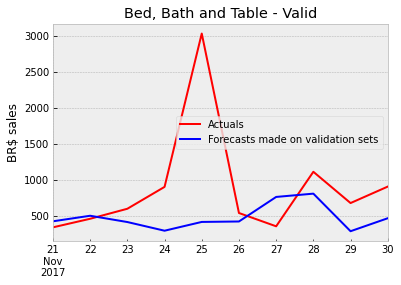

In [9]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Bed, Bath and Table - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [10]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','cama, mesa, banho, bed and bath - topic')
    mlflow.log_param('Product Category','Bed, Bath and Table')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 48a63a9d60cc4eacb75ebd8d446ff147


In [11]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 843810.8744536228
rms: 886.5401471179242
r2: -0.3906934237849058
mape: 0.4472588101841196


### Train & Run the XGBoost Model¶
Use optimized parameters determined by Hyperopt on the validation set

In [12]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

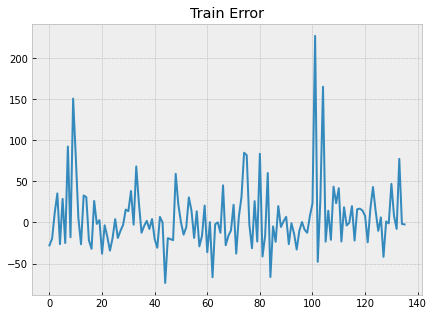

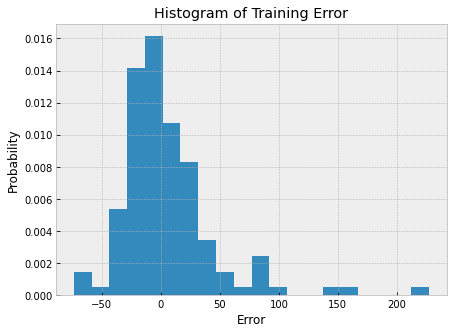

In [13]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(bed_bath_table_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(bed_bath_table_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [14]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [15]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 86784.63701613843
rms: 267.1734911534058
r2: 0.09499380885122688
mape: 0.6614594929463796


### Plot Actuals & Forecasts

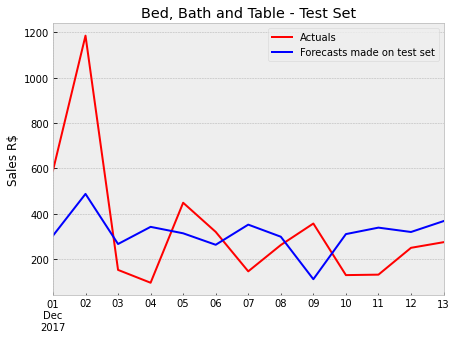

In [16]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Bed, Bath and Table - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

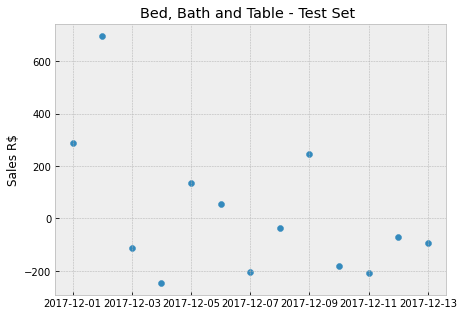

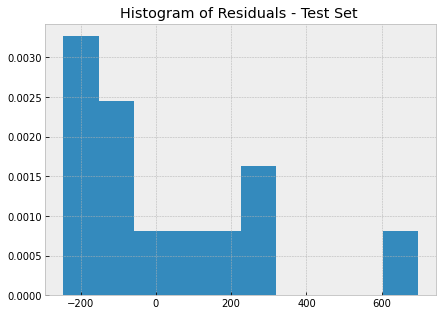

In [17]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Bed, Bath and Table - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

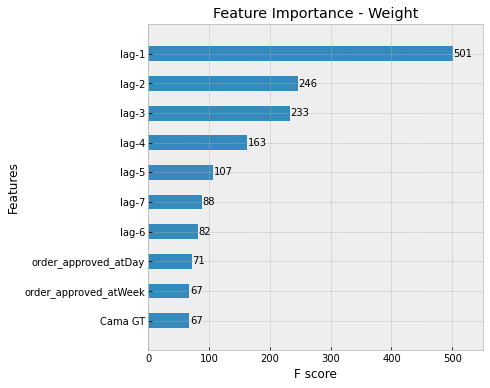

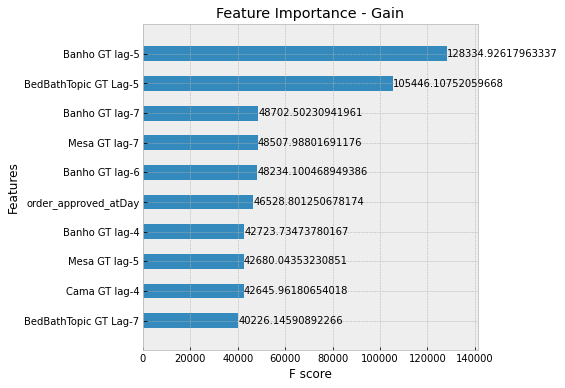

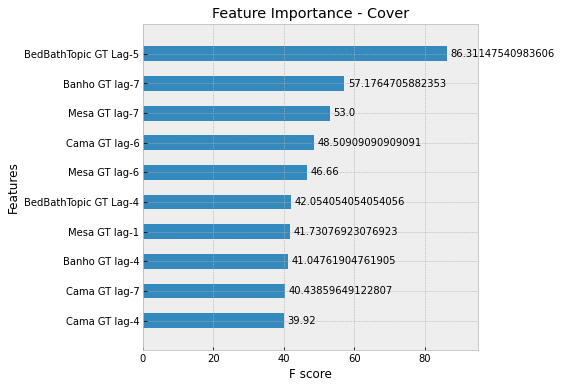

In [18]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [19]:
#Filter on product categories (series)
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty'].copy()
health_beauty_valid = df_valid.loc[df_valid['product_category_name'] == 'health_beauty'].copy()
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty'].copy()

#Read Google Trends Series
cosmetics_gt = pd.read_csv(os.path.join(base_dir_1,'cosmetics.csv'))
cosmetics_gt = cosmetics_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Make-Up & Cosmetics':'loja de cosmeticos gt'}) 
cosmetics_gt["loja de cosmeticos gt"] = pd.to_numeric(cosmetics_gt["loja de cosmeticos gt"], downcast="float")
cosmetics_gt['order_approved_at'] =  pd.to_datetime(cosmetics_gt['order_approved_at'], infer_datetime_format=True)

contem_gt = pd.read_csv(os.path.join(base_dir_1,'contem1g.csv'))
contem_gt = contem_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Contem 1g gt'}) 
contem_gt["Contem 1g gt"] = pd.to_numeric(contem_gt["Contem 1g gt"], downcast="float")
contem_gt['order_approved_at'] =  pd.to_datetime(contem_gt['order_approved_at'], infer_datetime_format=True)

natura_gt = pd.read_csv(os.path.join(base_dir_1,'Natura_Cosmetics.csv'))
natura_gt = natura_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Make-Up & Cosmetics':'Natura Cosmetics GT'}) 
natura_gt["Natura Cosmetics GT"] = pd.to_numeric(natura_gt["Natura Cosmetics GT"], downcast="float")
natura_gt['order_approved_at'] =  pd.to_datetime(natura_gt['order_approved_at'], infer_datetime_format=True)


surya_gt = pd.read_csv(os.path.join(base_dir_1,'Surya_Brasil.csv'))
surya_gt = surya_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Surya Brasil GT'}) 
surya_gt["Surya Brasil GT"] = pd.to_numeric(surya_gt["Surya Brasil GT"], downcast="float")
surya_gt['order_approved_at'] =  pd.to_datetime(surya_gt['order_approved_at'], infer_datetime_format=True)


#Extract lag features for Google Trends Series
utils.make_lag_features(cosmetics_gt, 7, 'loja de cosmeticos gt', 'loja de cosmeticos GT lag', inplace=True)
utils.make_lag_features(contem_gt, 7, 'Contem 1g gt', 'Contem 1g GT lag', inplace=True)
utils.make_lag_features(natura_gt, 7, 'Natura Cosmetics GT', 'Natura Cosmetics GT lag', inplace=True)
utils.make_lag_features(surya_gt, 7, 'Surya Brasil GT', 'Surya Brasil GT lag', inplace=True)

df = pd.merge(cosmetics_gt,contem_gt,how='inner',on='order_approved_at')
df2 = pd.merge(df,natura_gt,how='inner',on='order_approved_at')
google_trends_series = pd.merge(df2,surya_gt,how='inner',on='order_approved_at')

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()

#combine train,valid and test series
health_beauty_train = pd.merge(health_beauty_train, gt_train, how = 'inner', on='order_approved_at')
health_beauty_valid = pd.merge(health_beauty_valid, gt_valid, how = 'inner', on='order_approved_at')
health_beauty_test = pd.merge(health_beauty_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

health_beauty_train.drop(columns, inplace=True, axis=1)
health_beauty_valid.drop(columns, inplace=True, axis=1)
health_beauty_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = health_beauty_train.loc[:, health_beauty_train.columns != 'payment_value']
y_train = health_beauty_train.loc[:, health_beauty_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = health_beauty_valid.loc[:, health_beauty_valid.columns != 'payment_value']
y_val = health_beauty_valid.loc[:, health_beauty_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = health_beauty_test.loc[:, health_beauty_test.columns != 'payment_value']
y_test = health_beauty_test.loc[:, health_beauty_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)

### Hyperparameter Optimization Using Hyperopt

In [20]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [21]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:58<00:00,  3.41trial/s, best loss: 0.6389414419213718]
The best hyperparameters are: {'colsample_bytree': 0.9500000000000001, 'eta': 0.11, 'max_depth': 2, 'min_child_weight': 1.0, 'n_estimators': 29, 'subsample': 1.0}


In [22]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

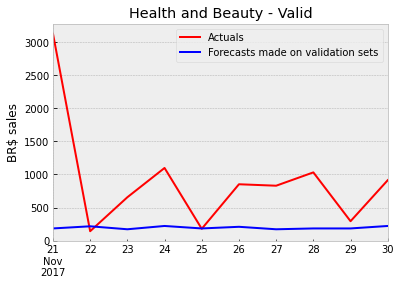

In [23]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Health and Beauty - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [24]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','loja de cosmetics, contem 1g, natura cosmetics, surya brasil')
    mlflow.log_param('Product Category','Health and Beauty')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 920336b253bf4429817f8661ee441c4e


In [25]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 1038556.222741353
rms: 1082.8031932795823
r2: -0.790678438795823
mape: 0.6397287109487297


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [26]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = health_beauty_train.loc[:, health_beauty_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

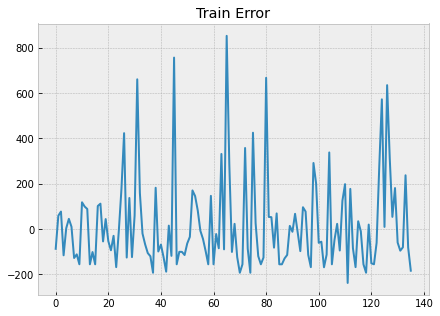

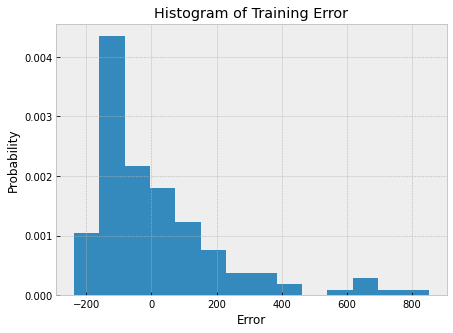

In [27]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(health_beauty_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(health_beauty_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [28]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [29]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 114057.2471423889
rms: 331.4658708859252
r2: -0.04068034978343005
mape: 33.60339791020031


### Plot Actuals & Forecasts

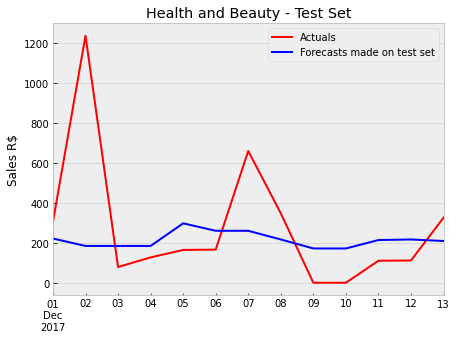

In [30]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Health and Beauty - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

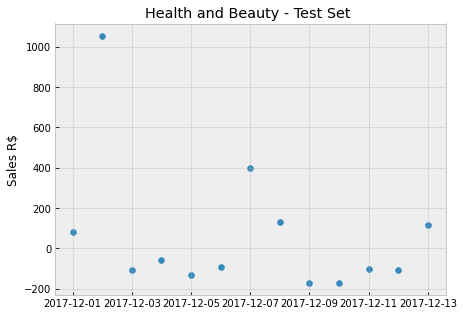

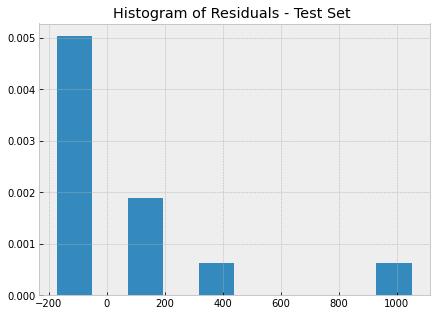

In [31]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Health and Beauty - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

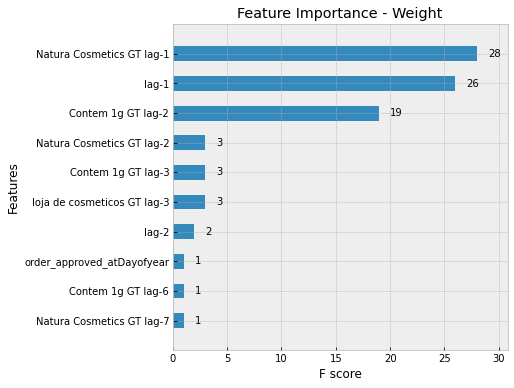

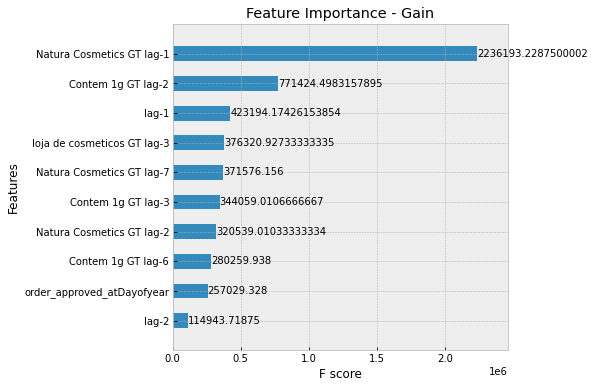

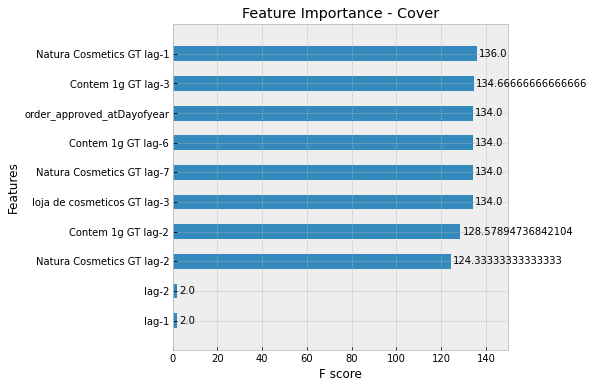

In [32]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [33]:
#Filter on product categories (series)
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_valid = df_valid.loc[df_valid['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure'].copy()

#Read Google Trends Series
nike_gt = pd.read_csv(os.path.join(base_dir_1,'Nike_Masculino.csv'))
nike_gt = nike_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Nike Masculino gt'}) 
nike_gt["Nike Masculino gt"] = pd.to_numeric(nike_gt["Nike Masculino gt"], downcast="float")
nike_gt['order_approved_at'] =  pd.to_datetime(nike_gt['order_approved_at'], infer_datetime_format=True)

adidas_gt = pd.read_csv(os.path.join(base_dir_1,'Adidas_Yeezy.csv'))
adidas_gt = adidas_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Adidas Yeezy gt'}) 
adidas_gt["Adidas Yeezy gt"] = pd.to_numeric(adidas_gt["Adidas Yeezy gt"], downcast="float")
adidas_gt['order_approved_at'] =  pd.to_datetime(adidas_gt['order_approved_at'], infer_datetime_format=True)

arezzo_gt = pd.read_csv(os.path.join(base_dir_1,'Arezzo.csv'))
arezzo_gt = arezzo_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Arezzo gt'}) 
arezzo_gt["Arezzo gt"] = pd.to_numeric(arezzo_gt["Arezzo gt"], downcast="float")
arezzo_gt['order_approved_at'] =  pd.to_datetime(arezzo_gt['order_approved_at'], infer_datetime_format=True)



#Extract lag features for Google Trends Series
utils.make_lag_features(nike_gt, 7, 'Nike Masculino gt', 'Nike Masculino GT lag', inplace=True)
utils.make_lag_features(adidas_gt, 7, 'Adidas Yeezy gt', 'Adidas Yeezy GT lag', inplace=True)
utils.make_lag_features(arezzo_gt, 7, 'Arezzo gt', 'Arezzo GT lag', inplace=True)

df = pd.merge(nike_gt,adidas_gt,how='inner',on='order_approved_at')

google_trends_series = pd.merge(df,arezzo_gt,how='inner',on='order_approved_at')

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(nike_gt['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()

#combine train,valid and test series
sports_leisure_train = pd.merge(sports_leisure_train, gt_train, how = 'inner', on='order_approved_at')
sports_leisure_valid = pd.merge(sports_leisure_valid, gt_valid, how = 'inner', on='order_approved_at')
sports_leisure_test = pd.merge(sports_leisure_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

sports_leisure_train.drop(columns, inplace=True, axis=1)
sports_leisure_valid.drop(columns, inplace=True, axis=1)
sports_leisure_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = sports_leisure_train.loc[:, sports_leisure_train.columns != 'payment_value']
y_train = sports_leisure_train.loc[:, sports_leisure_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = sports_leisure_valid.loc[:, sports_leisure_valid.columns != 'payment_value']
y_val = sports_leisure_valid.loc[:, sports_leisure_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = sports_leisure_test.loc[:, sports_leisure_test.columns != 'payment_value']
y_test = sports_leisure_test.loc[:, sports_leisure_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


C:\Users\feras\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Hyperparameter Optimization Using Hyperopt

In [34]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [35]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:38<00:00,  5.17trial/s, best loss: 0.42796307794558075]
The best hyperparameters are: {'colsample_bytree': 0.65, 'eta': 0.044, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 27, 'subsample': 0.5}


In [36]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

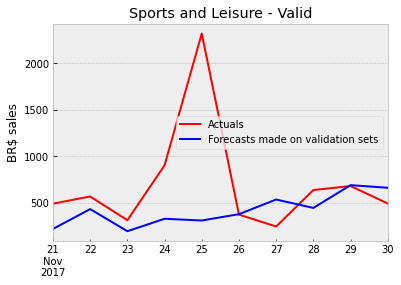

In [37]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Sports and Leisure - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [38]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','nike masculino, Adidas Yeezy, Arezzo')
    mlflow.log_param('Product Category','Sports and Leisure')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 278cf8a47e4d476497cea3b2a8416197


In [39]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 497764.7787882166
rms: 680.0332731913937
r2: -0.42935174772011675
mape: 0.4678062771305163


### Train & Run the XGBoost Model

In [40]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = sports_leisure_train.loc[:, sports_leisure_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

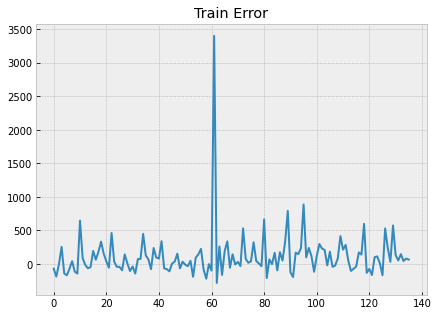

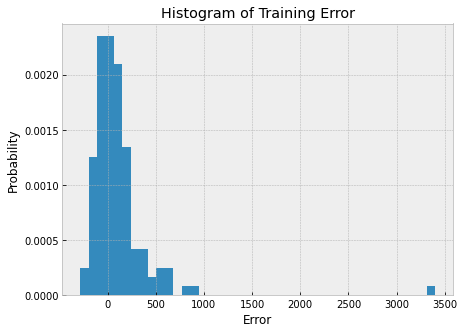

In [41]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(sports_leisure_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(sports_leisure_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [42]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [43]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 916596.3307763552
rms: 950.3025788040082
r2: -0.3715422319416988
mape: 0.5509501689884672


### Plot Actuals & Forecasts

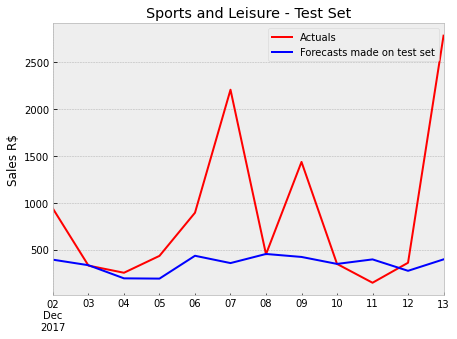

In [44]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Sports and Leisure - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

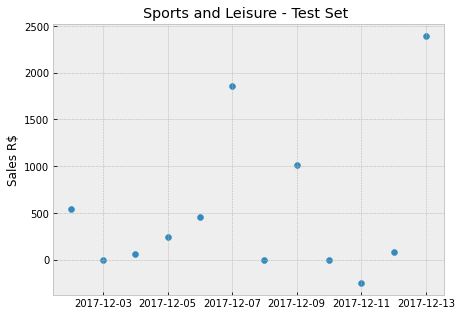

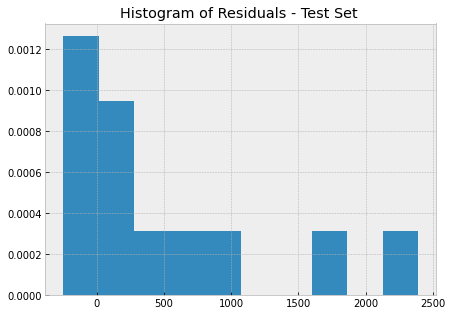

In [45]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Sports and Leisure - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

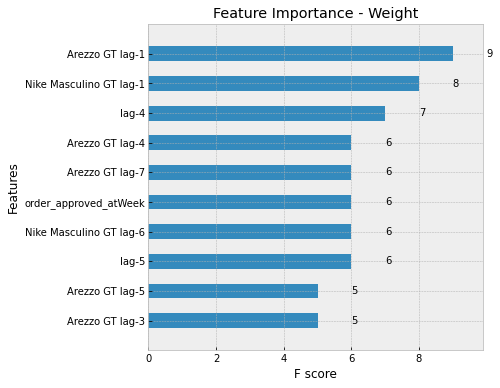

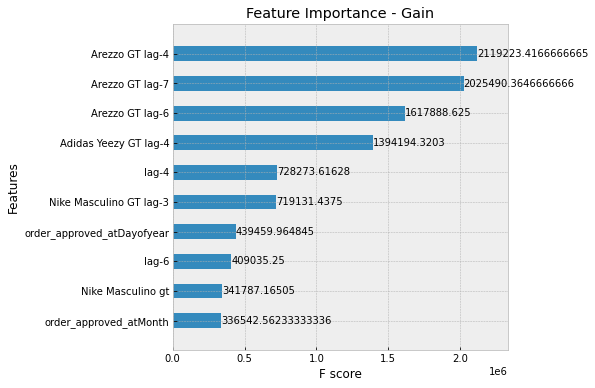

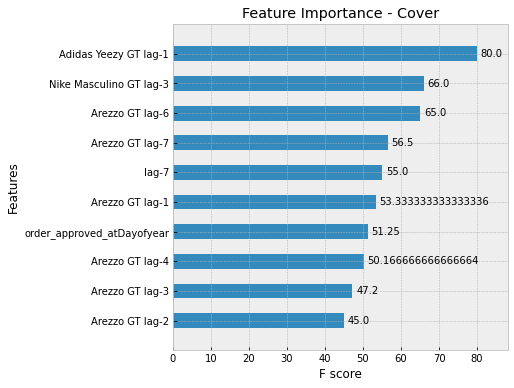

In [46]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [47]:
#Filter on product categories (series)
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_valid = df_valid.loc[df_valid['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor'].copy()

#Read Google Trends Series
couch_gt = pd.read_csv(os.path.join(base_dir_1,'Couch.csv'))
couch_gt = couch_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Home Furnishings':'Couch gt'}) 
couch_gt["Couch gt"] = pd.to_numeric(couch_gt["Couch gt"], downcast="float")
couch_gt['order_approved_at'] =  pd.to_datetime(couch_gt['order_approved_at'], infer_datetime_format=True)

furniture_gt = pd.read_csv(os.path.join(base_dir_1,'Furniture.csv'))
furniture_gt = furniture_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Home Furnishings':'Móveis gt'}) 
furniture_gt["Móveis gt"] = pd.to_numeric(furniture_gt["Móveis gt"], downcast="float")
furniture_gt['order_approved_at'] =  pd.to_datetime(furniture_gt['order_approved_at'], infer_datetime_format=True)

etna_gt = pd.read_csv(os.path.join(base_dir_1,'Etna.csv'))
etna_gt = etna_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Etna Móveis gt'}) 
etna_gt["Etna Móveis gt"] = pd.to_numeric(etna_gt["Etna Móveis gt"], downcast="float")
etna_gt['order_approved_at'] =  pd.to_datetime(etna_gt['order_approved_at'], infer_datetime_format=True)

xmasdecor_gt = pd.read_csv(os.path.join(base_dir_1,'xmas_decoration.csv'))
xmasdecor_gt = xmasdecor_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: All categories':'Christmas decoration gt'}) 
xmasdecor_gt["Christmas decoration gt"] = pd.to_numeric(xmasdecor_gt["Christmas decoration gt"], downcast="float")
xmasdecor_gt['order_approved_at'] =  pd.to_datetime(xmasdecor_gt['order_approved_at'], infer_datetime_format=True)


#Extract lag features for Google Trends Series
utils.make_lag_features(couch_gt, 7, 'Couch gt', 'Couch GT lag', inplace=True)
utils.make_lag_features(furniture_gt, 7, 'Móveis gt', 'Móveis GT lag', inplace=True)
utils.make_lag_features(etna_gt, 7, 'Etna Móveis gt', 'Etna Móveis GT lag', inplace=True)
utils.make_lag_features(xmasdecor_gt, 7, 'Christmas decoration gt', 'Christmas decoration GT lag', inplace=True)

df=pd.merge(couch_gt,furniture_gt,how='inner',on='order_approved_at')

df2=pd.merge(df,etna_gt,how='inner',on='order_approved_at')

google_trends_series = pd.merge(df2,xmasdecor_gt,how='inner',on='order_approved_at')

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()


#combine train,valid and test series
furniture_decor_train = pd.merge(furniture_decor_train, gt_train, how = 'inner', on='order_approved_at')
furniture_decor_valid = pd.merge(furniture_decor_valid, gt_valid, how = 'inner', on='order_approved_at')
furniture_decor_test = pd.merge(furniture_decor_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

furniture_decor_train.drop(columns, inplace=True, axis=1)
furniture_decor_valid.drop(columns, inplace=True, axis=1)
furniture_decor_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = furniture_decor_train.loc[:, furniture_decor_train.columns != 'payment_value']
y_train = furniture_decor_train.loc[:, furniture_decor_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = furniture_decor_valid.loc[:, furniture_decor_valid.columns != 'payment_value']
y_val = furniture_decor_valid.loc[:, furniture_decor_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = furniture_decor_test.loc[:, furniture_decor_test.columns != 'payment_value']
y_test = furniture_decor_test.loc[:, furniture_decor_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)



### Hyperparameter Optimization Using Hyperopt

In [48]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [49]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:53<00:00,  3.74trial/s, best loss: 0.7262746207317317]
The best hyperparameters are: {'colsample_bytree': 0.5, 'eta': 0.018000000000000002, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 32, 'subsample': 0.6000000000000001}


In [50]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

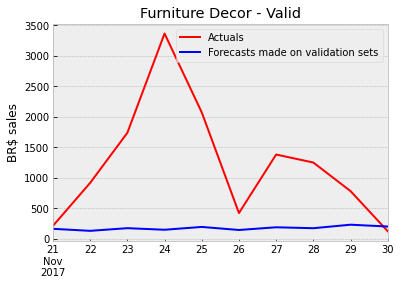

In [51]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Furniture Decor - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [52]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','couch, Móveis, Etna Móveis, Christmas decoration')
    mlflow.log_param('Product Category','Furniture Decor')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 00318321e9fb46179544e0bae59a86bd


In [53]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 1608857.0526752705
rms: 1410.6202168059729
r2: -1.2727269233071206
mape: 0.7291111856537209


### Train & Run the XGBoost Model

In [54]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = furniture_decor_train.loc[:, furniture_decor_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

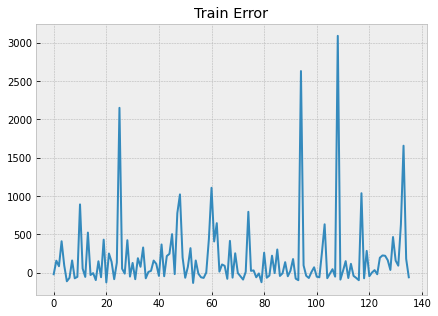

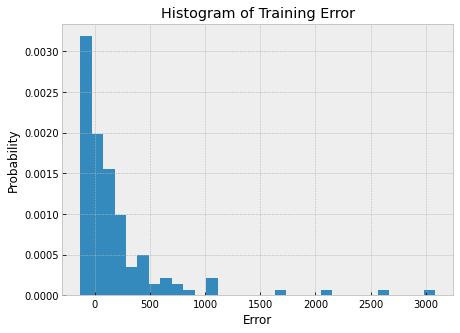

In [55]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(furniture_decor_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(furniture_decor_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [56]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [57]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 292109.5075449267
rms: 565.0165967349633
r2: -0.2833144181138125
mape: 26.17461088636487


### Plot Actuals & Forecasts

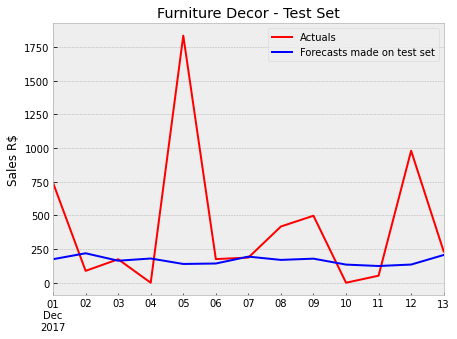

In [58]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Furniture Decor - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

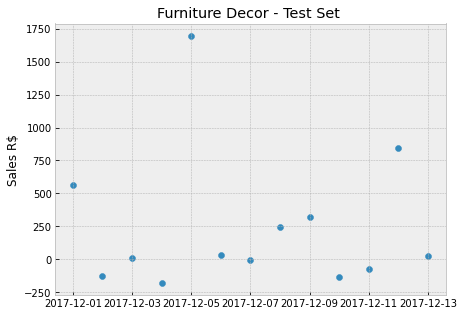

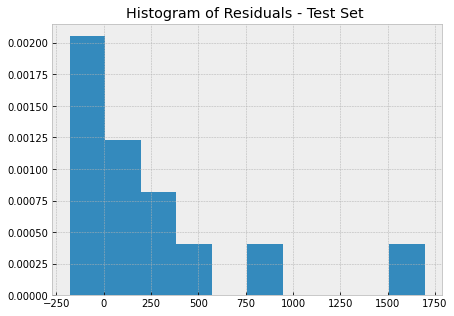

In [59]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Furniture Decor - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

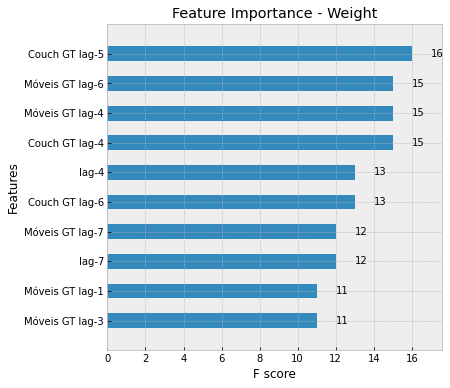

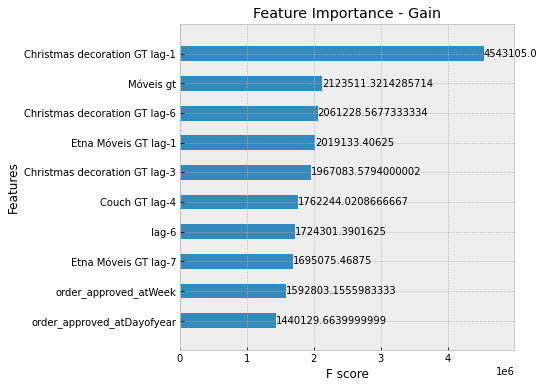

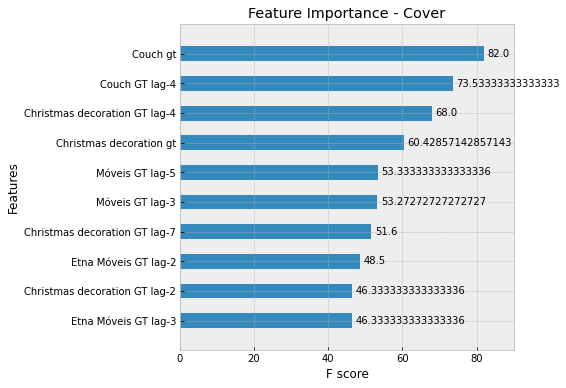

In [60]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [61]:
#Filter on product categories (series)
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_valid = df_valid.loc[df_valid['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts'].copy()

#Read Google Trends Series
watches_gt = pd.read_csv(os.path.join(base_dir_1,'Watches.csv'))
watches_gt = watches_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Watches gt'}) 
watches_gt["Watches gt"] = pd.to_numeric(watches_gt["Watches gt"], downcast="float")
watches_gt['order_approved_at'] =  pd.to_datetime(watches_gt['order_approved_at'], infer_datetime_format=True)

gifts_gt = pd.read_csv(os.path.join(base_dir_1,'Gifts.csv'))
gifts_gt = gifts_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Gifts gt'}) 
gifts_gt["Gifts gt"] = pd.to_numeric(gifts_gt["Gifts gt"], downcast="float")
gifts_gt['order_approved_at'] =  pd.to_datetime(gifts_gt['order_approved_at'], infer_datetime_format=True)


#Extract lag features for Google Trends Series
utils.make_lag_features(watches_gt, 7, 'Watches gt', 'Watches GT lag', inplace=True)
utils.make_lag_features(gifts_gt, 7, 'Gifts gt', 'Gifts GT lag', inplace=True)

google_trends_series = pd.merge(watches_gt,gifts_gt,how='inner',on='order_approved_at')


gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()

#combine train,valid and test series
watches_gifts_train = pd.merge(watches_gifts_train, gt_train, how = 'inner', on='order_approved_at')
watches_gifts_valid = pd.merge(watches_gifts_valid, gt_valid, how = 'inner', on='order_approved_at')
watches_gifts_test = pd.merge(watches_gifts_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

watches_gifts_train.drop(columns, inplace=True, axis=1)
watches_gifts_valid.drop(columns, inplace=True, axis=1)
watches_gifts_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = watches_gifts_train.loc[:, watches_gifts_train.columns != 'payment_value']
y_train = watches_gifts_train.loc[:, watches_gifts_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = watches_gifts_valid.loc[:, watches_gifts_valid.columns != 'payment_value']
y_val = watches_gifts_valid.loc[:, watches_gifts_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = watches_gifts_test.loc[:, watches_gifts_test.columns != 'payment_value']
y_test = watches_gifts_test.loc[:, watches_gifts_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)



### Hyperparameter Optimization Using Hyperopt

In [62]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [63]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:46<00:00,  4.30trial/s, best loss: 2.868546416955244] 
The best hyperparameters are: {'colsample_bytree': 0.55, 'eta': 0.015, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 6, 'subsample': 0.7000000000000001}


In [64]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

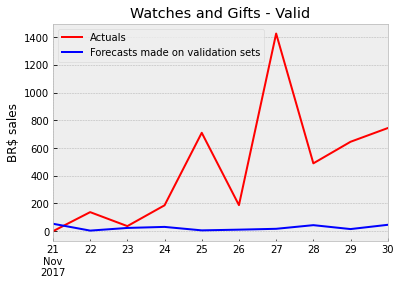

In [65]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Watches and Gifts - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [66]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','watches,gifts')
    mlflow.log_param('Product Category','Watches and Gifts')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 84ae114f82784f969db71810fb1ce7bf


In [67]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 279885.2454383533
rms: 603.0111892343174
r2: -1.0737352285961346
mape: 3.3135837026185255


### Train & Run the XGBoost Model

In [68]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = watches_gifts_train.loc[:, watches_gifts_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

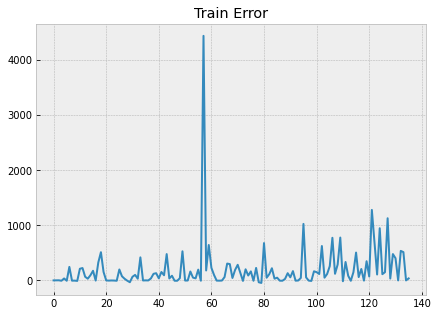

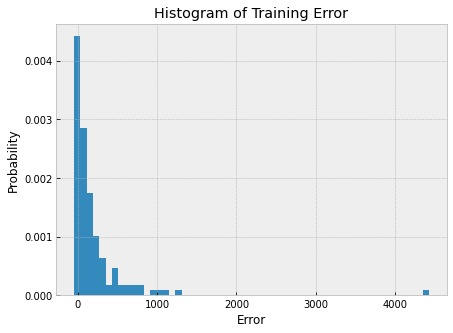

In [69]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(watches_gifts_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(watches_gifts_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [70]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [71]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 92274.94361000598
rms: 332.2119388439916
r2: -0.7841553416375742
mape: 0.680715810080875


### Plot Actuals & Forecasts

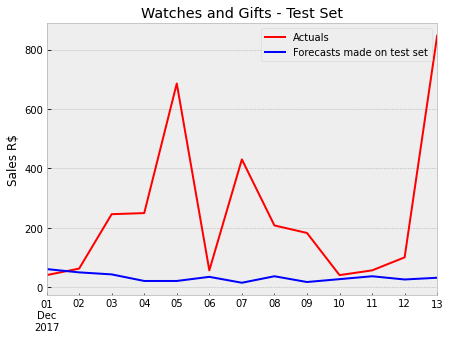

In [72]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Watches and Gifts - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

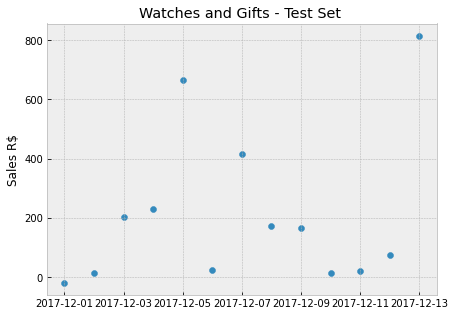

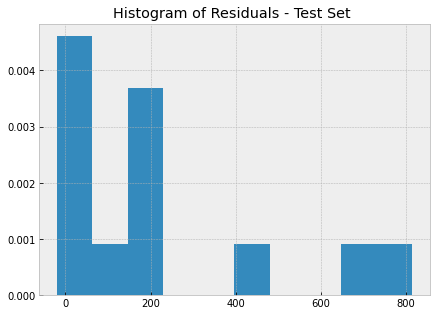

In [73]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Watches and Gifts - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

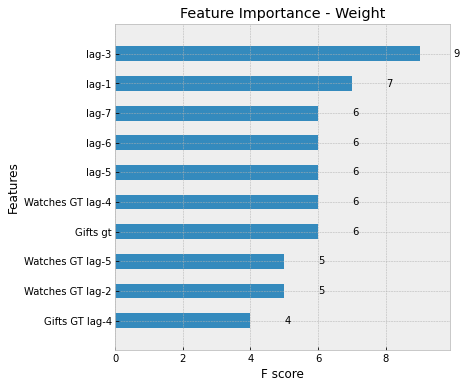

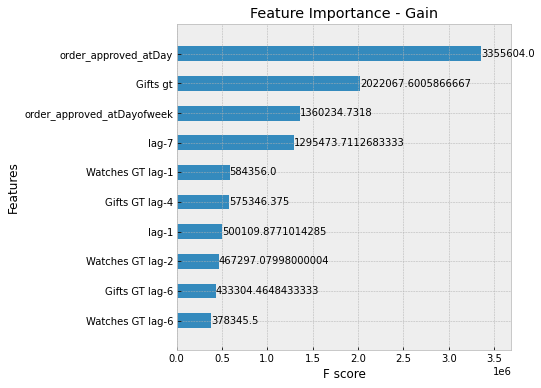

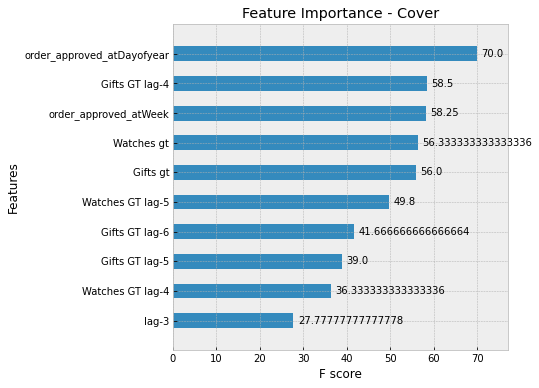

In [74]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 6: Telephony <a name = "telephony"/>

In [75]:
#Filter on product categories (series)
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony'].copy()
telephony_valid = df_valid.loc[df_valid['product_category_name'] == 'telephony'].copy()
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony'].copy()


#Read Google Trends Series
iphone8_gt = pd.read_csv(os.path.join(base_dir_1,'iphone8.csv'))
iphone8_gt = iphone8_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'iphone 8'}) 
iphone8_gt["iphone 8"] = pd.to_numeric(iphone8_gt["iphone 8"], downcast="float")
iphone8_gt['order_approved_at'] =  pd.to_datetime(iphone8_gt['order_approved_at'], infer_datetime_format=True)

iphonex_gt = pd.read_csv(os.path.join(base_dir_1,'iphonex.csv'))
iphonex_gt = iphonex_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'iphone x'}) 
iphonex_gt["iphone x"] = pd.to_numeric(iphonex_gt["iphone x"], downcast="float")
iphonex_gt['order_approved_at'] =  pd.to_datetime(iphonex_gt['order_approved_at'], infer_datetime_format=True)

galaxyS5_gt = pd.read_csv(os.path.join(base_dir_1,'SamsungGalaxyS5.csv'))
galaxyS5_gt = galaxyS5_gt.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Samsung Galaxy S5'}) 
galaxyS5_gt["Samsung Galaxy S5"] = pd.to_numeric(galaxyS5_gt["Samsung Galaxy S5"], downcast="float")
galaxyS5_gt['order_approved_at'] =  pd.to_datetime(galaxyS5_gt['order_approved_at'], infer_datetime_format=True)


#Extract lag features for Google Trends Series
utils.make_lag_features(iphone8_gt, 7, 'iphone 8', 'iphone 8 GT lag', inplace=True)
utils.make_lag_features(iphonex_gt, 7, 'iphone x', 'iphone x GT lag', inplace=True)
utils.make_lag_features(galaxyS5_gt, 7, 'Samsung Galaxy S5', 'Samsung Galaxy S5 GT lag', inplace=True)

df=pd.merge(iphone8_gt,iphonex_gt,how='inner',on='order_approved_at')

google_trends_series=pd.merge(df,galaxyS5_gt,how='inner',on='order_approved_at')

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()


#combine train,valid and test series
telephony_train = pd.merge(telephony_train, gt_train, how = 'inner', on='order_approved_at')
telephony_valid = pd.merge(telephony_valid, gt_valid, how = 'inner', on='order_approved_at')
telephony_test = pd.merge(telephony_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

telephony_train.drop(columns, inplace=True, axis=1)
telephony_valid.drop(columns, inplace=True, axis=1)
telephony_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = telephony_train.loc[:, telephony_train.columns != 'payment_value']
y_train = telephony_train.loc[:, telephony_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = telephony_valid.loc[:, telephony_valid.columns != 'payment_value']
y_val = telephony_valid.loc[:, telephony_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = telephony_test.loc[:, telephony_test.columns != 'payment_value']
y_test = telephony_test.loc[:, telephony_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [76]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [77]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:42<00:00,  4.67trial/s, best loss: 1.5715486005857855]
The best hyperparameters are: {'colsample_bytree': 0.55, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 5, 'subsample': 0.6000000000000001}


In [78]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

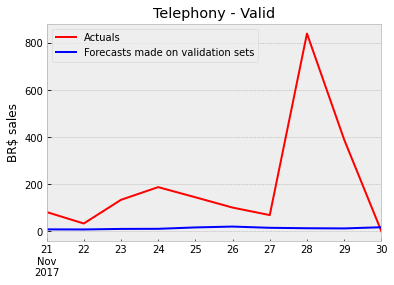

In [79]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Telephony - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [80]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','iphone 8, iphone x, samsung galaxy s5')
    mlflow.log_param('Product Category','Telephony')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 084975efe281470e9e1c7abf0d71d89c


In [81]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 77906.9132291541
rms: 300.8966164786719
r2: -0.6110195432473295
mape: 2.047616054187485


### Train & Run the XGBoost Model

In [82]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = telephony_train.loc[:, telephony_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

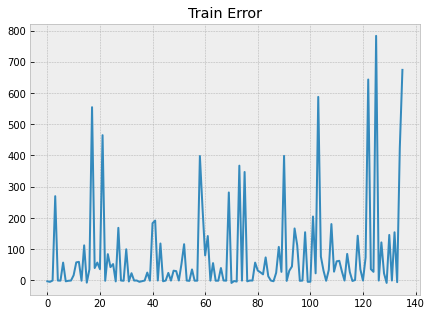

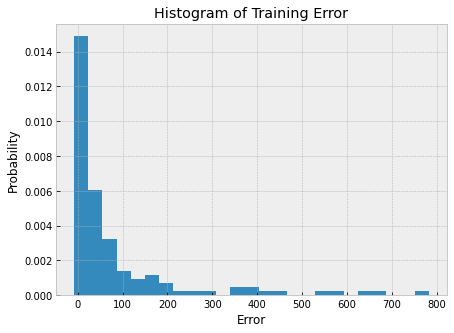

In [83]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(telephony_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(telephony_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [84]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [85]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 73551.64425051122
rms: 281.58908958470965
r2: -0.7272777697103663
mape: 2.557745504871649


### Plost Actuals & Forecasts

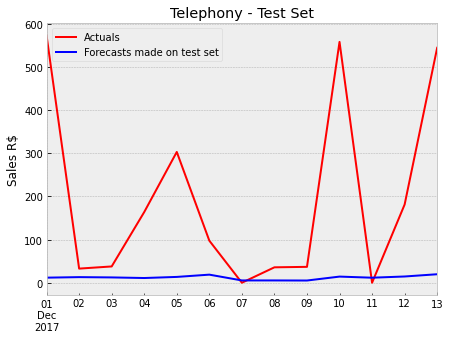

In [86]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Telephony - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

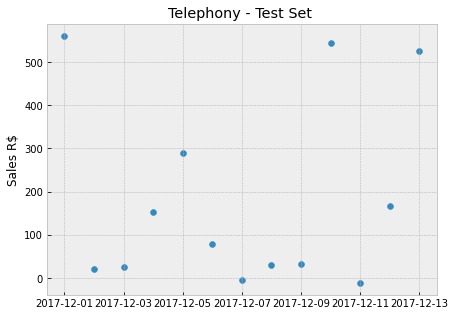

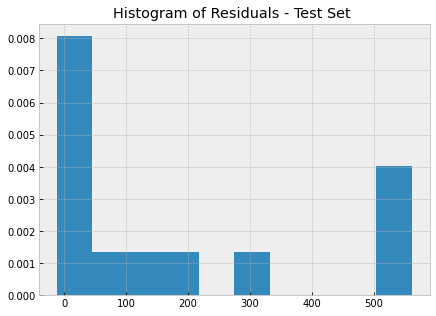

In [87]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Telephony - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

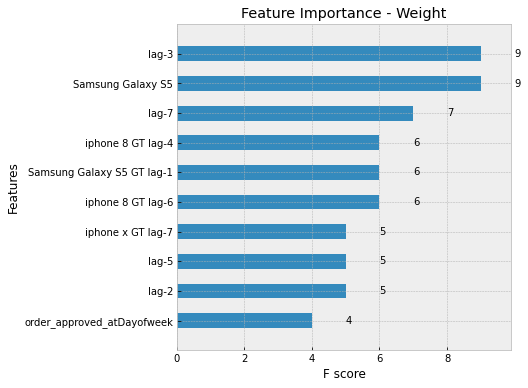

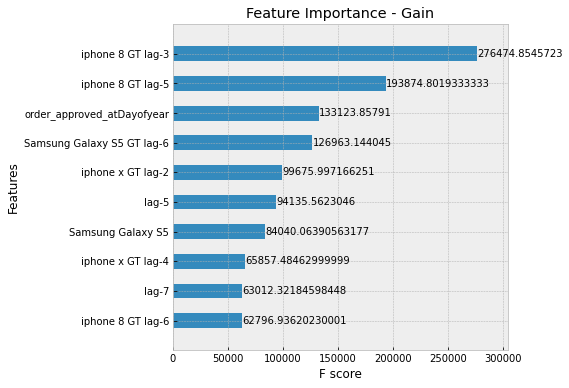

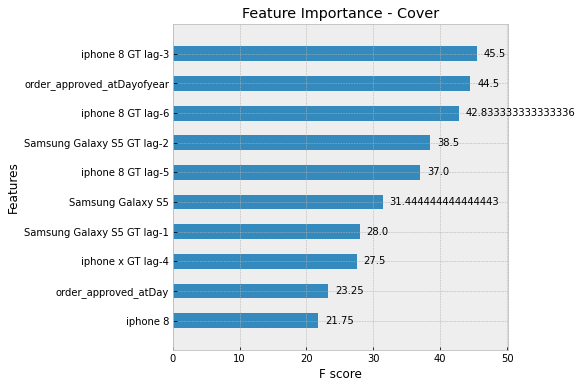

In [88]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

# Product Category 7: Housewares <a name = "housewares"/>

In [89]:
#Filter on product categories (series)
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares'].copy()
housewares_valid = df_valid.loc[df_valid['product_category_name'] == 'housewares'].copy()
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares'].copy()

cama_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Cama_Shopping.csv'))
mesa_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Mesa_Shopping.csv'))
banho_gt_shopping = pd.read_csv(os.path.join(base_dir_1,'Banho_Shopping.csv'))
bed_bath_topic = pd.read_csv(os.path.join(base_dir_1,'Bed_Bath_Topic.csv'))

cama_gt_shopping = cama_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Cama GT'}) 
mesa_gt_shopping = mesa_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Mesa GT'}) 
banho_gt_shopping = banho_gt_shopping.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Shopping':'Banho GT'}) 
bed_bath_topic = bed_bath_topic.reset_index().iloc[1:].rename(columns={'index':'order_approved_at','Category: Bed & Bath':'Bed and Bath GT'}) 

df = pd.merge(cama_gt_shopping,mesa_gt_shopping,how='inner',on='order_approved_at')
df2 = pd.merge(df,banho_gt_shopping,how='inner',on='order_approved_at')
google_trends_series = pd.merge(df2,bed_bath_topic,how='inner',on='order_approved_at')
google_trends_series['order_approved_at'] =  pd.to_datetime(google_trends_series['order_approved_at'], infer_datetime_format=True)

google_trends_series["Cama GT"] = pd.to_numeric(google_trends_series["Cama GT"], downcast="float")
google_trends_series["Mesa GT"] = pd.to_numeric(google_trends_series["Mesa GT"], downcast="float")
google_trends_series["Banho GT"] = pd.to_numeric(google_trends_series["Banho GT"], downcast="float")
google_trends_series["Bed and Bath GT"] = pd.to_numeric(google_trends_series["Bed and Bath GT"], downcast="float")


#Extract lag features for Google Trends Series
utils.make_lag_features(google_trends_series, 7, 'Cama GT', 'Cama GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Mesa GT', 'Mesa GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Banho GT', 'Banho GT lag', inplace=True)
utils.make_lag_features(google_trends_series, 7, 'Bed and Bath GT', 'BedBathTopic GT Lag', inplace=True)

#Split Google Trends into train,valid and test sets. Drop NaaN rows equal to the lag size in train set.

gt_train = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-07-01')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-11-21'))].copy()
gt_train = gt_train.dropna()

gt_valid = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-11-21')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-1'))].copy()

gt_test = google_trends_series[(google_trends_series['order_approved_at'] >= pd.Timestamp('2017-12-1')) &
                         (google_trends_series['order_approved_at'] < pd.Timestamp('2017-12-14'))].copy()

#combine train,valid and test series
housewares_train = pd.merge(housewares_train, gt_train, how = 'inner', on='order_approved_at')
housewares_valid = pd.merge(housewares_valid, gt_valid, how = 'inner', on='order_approved_at')
housewares_test = pd.merge(housewares_test, gt_test, how = 'inner', on='order_approved_at')

#Drop columns that are no longer required
columns = ['product_category_name','order_approved_at']

housewares_train.drop(columns, inplace=True, axis=1)
housewares_valid.drop(columns, inplace=True, axis=1)
housewares_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = housewares_train.loc[:, housewares_train.columns != 'payment_value']
y_train = housewares_train.loc[:, housewares_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = housewares_valid.loc[:, housewares_valid.columns != 'payment_value']
y_val = housewares_valid.loc[:, housewares_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = housewares_test.loc[:, housewares_test.columns != 'payment_value']
y_test = housewares_test.loc[:, housewares_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [90]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [91]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:54<00:00,  3.68trial/s, best loss: 0.419900840561062]  
The best hyperparameters are: {'colsample_bytree': 0.9500000000000001, 'eta': 0.193, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 48, 'subsample': 0.55}


In [92]:
num_rounds = params.pop('n_estimators')

###  Report & Visualize Performance on the Validation Set

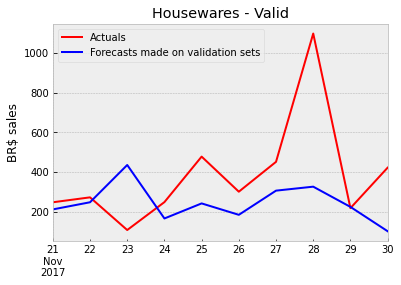

In [93]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

#Plot

valid_dates = gt_valid.pop('order_approved_at').unique()
test_dates = gt_test.pop('order_approved_at').unique()

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Housewares - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [94]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Google Trends Series','cama, mesa, banho, bed and bath - topic')
    mlflow.log_param('Product Category','Housewares')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: f24939dc8d7140709acbd97a1d004b5a


In [95]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 99652.88672036407
rms: 300.5281762961846
r2: -0.3211961611553915
mape: 0.4859921518198761


### Train & Run the XGBoost Model

In [96]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = housewares_train.loc[:, housewares_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

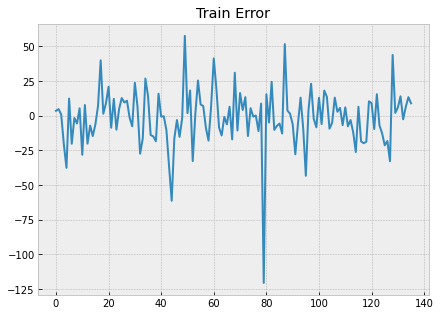

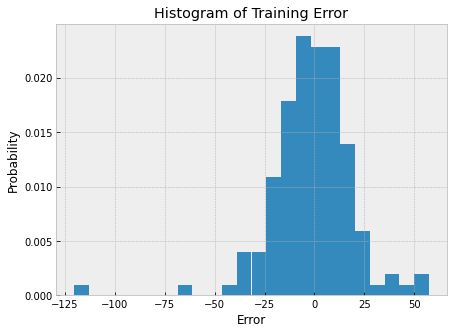

In [97]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(housewares_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(housewares_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [98]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [99]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 268668.4692577646
rms: 549.6880798636028
r2: -0.3656729142741961
mape: 34.09488790541199


### Plot Actuals & Forecasts

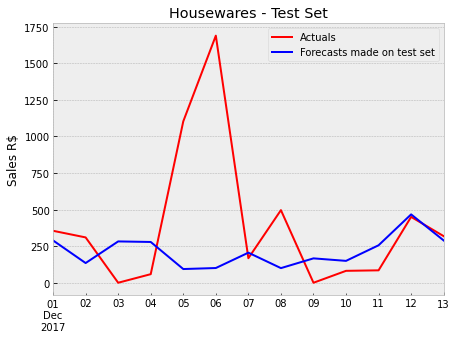

In [100]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Housewares - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

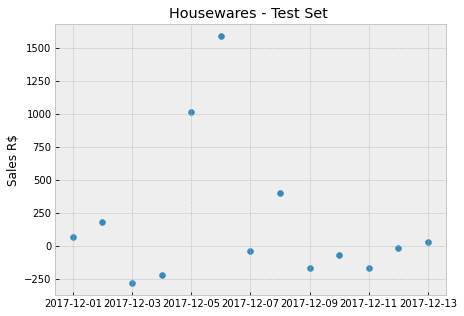

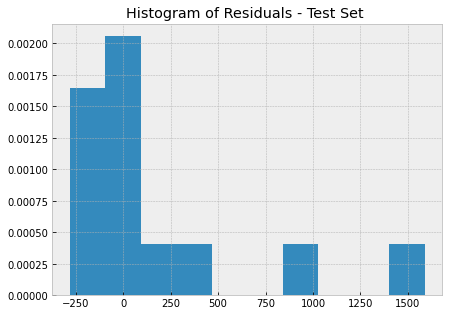

In [101]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Housewares - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

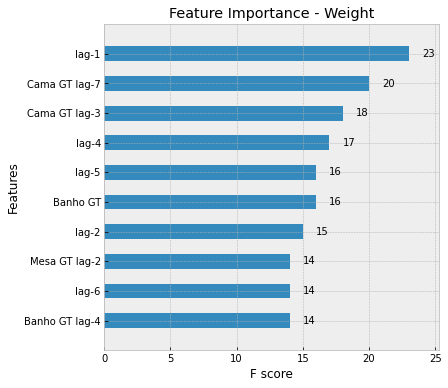

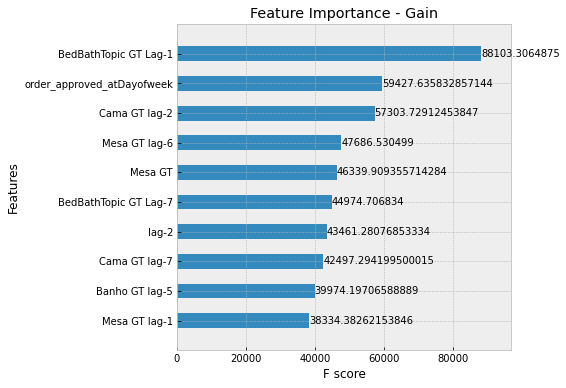

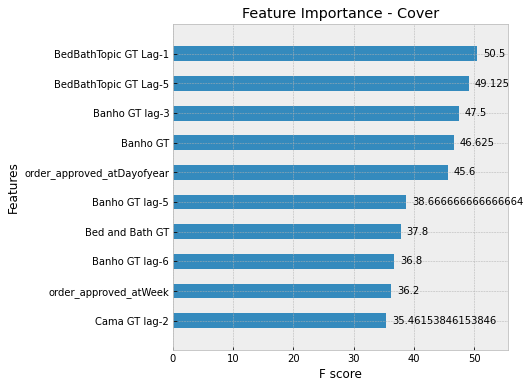

In [102]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()